# A/B Test of New Design

#### Author : Nicodemus Naisau (demsroadmap@gmail.com)

<a href="https://nicodemusnaisau.medium.com/a-b-test-of-new-design-14211b0a5da9" target=_blank>
<img src="https://www.optimizely.com/contentassets/08726e145f1b4743a0ba2f30c0447b76/ab-testing.png"
     alt="AB img assets"
     style="float: center" /></a>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from pathlib import Path

import warnings
warnings.filterwarnings("ignore") 

#style definition
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Sans',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [2]:
df = pd.read_csv("ab_data.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [3]:
#current conversion rate = 0,13
#expected conversion rate = 0,15
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [4]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [5]:
df['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [6]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [8]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


##  Sampling

In [9]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [10]:
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,4720
treatment,4720,0


## Conversion Rate

In [11]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


In [12]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])

In [13]:
ab_test1 = ab_test.loc[ab_test['group'] == 'control']
ab_test1

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
4715,646677,2017-01-17 15:34:00.011127,control,old_page,0
4716,895315,2017-01-07 02:41:17.321930,control,old_page,0
4717,648194,2017-01-16 22:44:54.889419,control,old_page,0
4718,872383,2017-01-12 23:47:30.689899,control,old_page,0


In [14]:
np.mean(ab_test1.converted)

0.12330508474576271

In [15]:
ab_test2 = ab_test.loc[ab_test['group'] == 'treatment']
ab_test2
#

,user_id,timestamp,group,landing_page,converted
4720,860447,2017-01-11 21:20:47.193292,treatment,new_page,0
4721,845654,2017-01-06 21:49:33.725054,treatment,new_page,0
4722,833106,2017-01-11 21:56:24.637002,treatment,new_page,0
4723,665687,2017-01-08 04:17:45.135586,treatment,new_page,0
4724,658409,2017-01-22 13:18:58.765132,treatment,new_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [16]:
np.mean(ab_test2.converted)

0.125635593220339

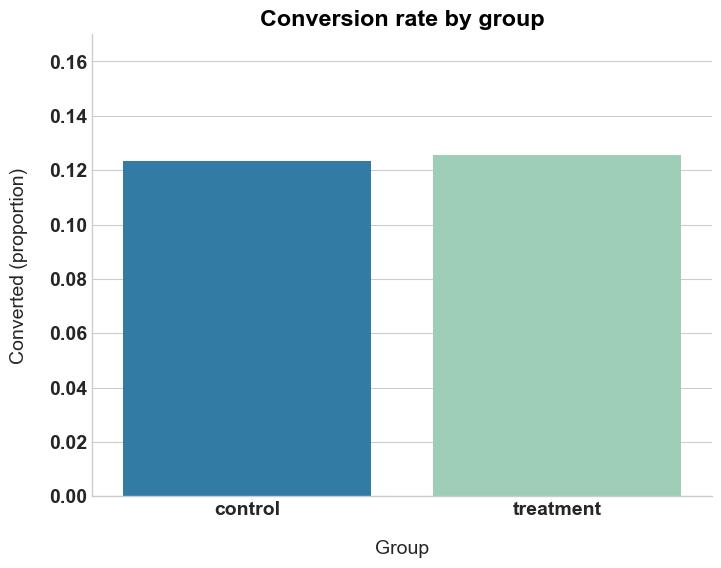

In [21]:
plt.figure(figsize=(8,6))

ax = sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False,palette="YlGnBu_r")


for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.ylim(0, 0.17)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)    
    
ax.set_title(
        "Conversion rate by group",
        fontdict={"fontweight": "bold"},
        color='black'
    )
plt.savefig(
        Path(".") / "plots" / f"conversion_rate_by_group.png",
        bbox_inches="tight",
        dpi=200,
    )
 # gives room for the annotations



## Test Hypothesis

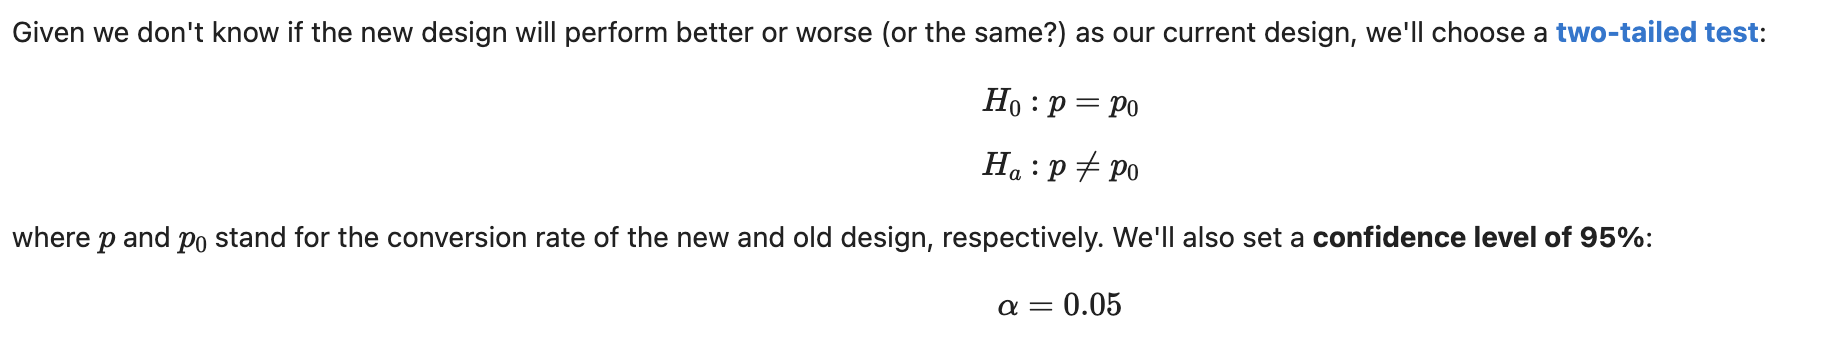

In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
control_results

0       0
1       0
2       0
3       0
4       0
       ..
4715    0
4716    0
4717    0
4718    0
4719    0
Name: converted, Length: 4720, dtype: int64

In [19]:
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
treatment_results

4720    0
4721    0
4722    0
4723    0
4724    0
       ..
9435    0
9436    0
9437    0
9438    0
9439    1
Name: converted, Length: 4720, dtype: int64

In [20]:
n_con = control_results.count() #4719
n_treat = treatment_results.count()  #4719
successes = [control_results.sum(), treatment_results.sum()] #jmlh yg transaksi brp
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
#(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'p-value: {pval:.3f}')

p-value: 0.732


## Results

- The p-value for the test was 0.732, which is above the alpha level of 0.05. Therefore, **we cannot reject the null hypothesis**. 
- This suggests that the **new design is not significantly different from the current design** in terms of performance.